In [1]:
%load_ext autoreload
%autoreload 2

Epoch 1/10, Loss: 0.9196
Epoch 2/10, Loss: 0.3782
Epoch 3/10, Loss: 0.3080
Epoch 4/10, Loss: 0.2815
Epoch 5/10, Loss: 0.2433
Epoch 6/10, Loss: 0.2146
Epoch 7/10, Loss: 0.1949
Epoch 8/10, Loss: 0.1697
Epoch 9/10, Loss: 0.1520
Epoch 10/10, Loss: 0.1405


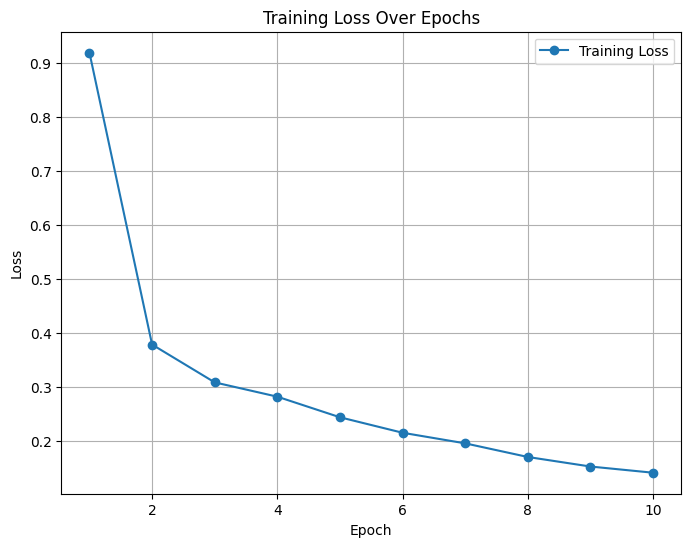

Validation Accuracy: 93.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split, Subset
from hyperparameters import get_hyperparams
from data import get_data_loaders
from models import MNISTClassifier
from train import train
from evaluate import evaluate

batch_size, learning_rate, epochs, validation_split = get_hyperparams()

train_loader, val_loader = get_data_loaders(validation_split, batch_size)

# Initialize model, loss function, and optimizer
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(epochs, model, train_loader, criterion, optimizer)
evaluate(model, val_loader)


In [53]:
from models import LSClassifier
from data import get_data_sets
import torch
from evaluate import evaluate
import itertools
from torch.utils.data import DataLoader

from hyperparameters import get_hyperparams

batch_size, learning_rate, epochs, validation_split = get_hyperparams()

train_set, val_set = get_data_sets(validation_split)


# Extract tensors from the dataset and flatten them
train_data = torch.stack([torch.flatten(data) for data, _ in train_set])
train_labels = torch.nn.functional.one_hot(torch.tensor([label for _, label in train_set])).float()
val_data = torch.stack([torch.flatten(data) for data, _ in val_set])
val_labels = torch.tensor([label for _, label in val_set])


model = LSClassifier(train_data, train_labels)

result = evaluate(model, [(val_data, val_labels)])

# not surprisingly, the model does not fit to the data well. The reason is that
# the model assumes a gaussian distribution for the data, whereas the data is
# the data binary target values clearly have a distribution far from gaussian.
# You can read more with the new Bishop at page 137.

Validation Accuracy: 58.50%
Confusion Matrix:
[[12  0  2  1  0  2  1  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0]
 [ 3  2  5  3  0  3  1  0  5  0]
 [ 0  1  3  7  0  2  0  0  1  3]
 [ 1  0  1  1 13  3  0  0  1  0]
 [ 0  1  1  2  1 13  2  0  2  0]
 [ 0  1  0  0  1  1 10  0  0  1]
 [ 0  2  1  2  0  1  2 13  2  5]
 [ 0  6  0  2  0  1  0  0 11  0]
 [ 0  1  3  0  0  1  0  1  0 10]]
Precision: 0.6001
Recall: 0.5900
F1 Score: 0.5790


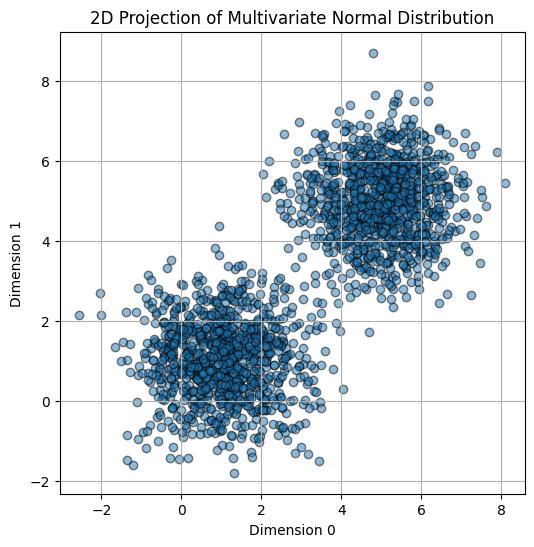

In [25]:
import torch
import matplotlib.pyplot as plt

num_classes = 2
num_features = 784

means = torch.randn(num_classes, num_features)
covs = torch.randn(num_classes, num_features, num_features)

means = torch.ones(num_classes, num_features)
row_indices = torch.arange(start=0, end=4*num_classes, step=4).unsqueeze(1)  # Shape: (num_classes, 1)
means += row_indices 
covs = torch.eye(num_features).unsqueeze(0).repeat(num_classes, 1, 1)
# make it symmetric positive definite
covs = torch.bmm(covs, covs.permute(0, 2, 1))

dists: list[torch.distributions.Distribution] = []
for i in range(num_classes):
    dists.append(torch.distributions.MultivariateNormal(means[i], covs[i]))

# Sample from the distribution
samples = []
for dist in dists:
    sample = dist.sample((1000,))  # Generate 1000 samples
    samples.append(sample)
samples = torch.cat(samples, dim=0)

# Choose two dimensions for plotting (e.g., 0 and 1)
x = samples[:, 0]
y = samples[:, 1]

# Plot the distribution
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5, edgecolor='k')
plt.title("2D Projection of Multivariate Normal Distribution")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.grid(True)
plt.axis('equal')
plt.show()

In [30]:
from dataclasses import dataclass
from typing import Iterator
from evaluate import evaluate
from data import get_data_loaders

@dataclass
class GMMParameters:
    means: torch.Tensor
    covariances: torch.Tensor
    priors: torch.Tensor
    
def expectation_step(gmm_parameters, data):
    means = gmm_parameters.means
    covariances = gmm_parameters.covariances
    priors = gmm_parameters.priors
    N, D = data.shape
    K = means.shape[0]
    responsibilities = torch.zeros(N, K)
    
    for k in range(K):
        mvn = torch.distributions.MultivariateNormal(means[k], covariances[k])
        responsibilities[:, k] = priors[k] * mvn.log_prob(data).exp()  # Use log_prob for stability
    
    # Normalize to get probabilities
    responsibilities /= responsibilities.sum(dim=1, keepdim=True)
    
    return responsibilities

def maximization_step(responsibilities, data):
    N, D = data.shape
    K = responsibilities.shape[1]
    
    # Compute the total responsibility assigned to each cluster
    Nk = responsibilities.sum(dim=0)
    
    # Update the means
    means = torch.zeros(K, D)
    for k in range(K):
        means[k] = (responsibilities[:, k].unsqueeze(-1) * data).sum(dim=0) / Nk[k]
    
    # Update the covariances
    covariances = torch.zeros(K, D, D)
    for k in range(K):
        diff = data - means[k]
        covariances[k] = (responsibilities[:, k].unsqueeze(-1) * diff).T @ diff / Nk[k]
    
    # Update the priors
    priors = Nk / N
    
    return GMMParameters(means, covariances, priors)

def em_algorithm(gmm_parameters: GMMParameters, data: Iterator[torch.Tensor], max_iter=100):
    for _ in range(max_iter):
        for batch in data:
            responsibilities = expectation_step(gmm_parameters, batch)
            gmm_parameters = maximization_step(responsibilities, batch)
    return gmm_parameters

def evaluate_log_likelihood(gmm_parameters, val_data):
    means = gmm_parameters.means
    covariances = gmm_parameters.covariances
    priors = gmm_parameters.priors
    log_likelihoods = torch.zeros(len(val_data))

    for i, x in enumerate(val_data):
        component_log_probs = torch.zeros(len(priors))
        for k in range(len(priors)):
            mvn = torch.distributions.MultivariateNormal(means[k], covariances[k])
            component_log_probs[k] = priors[k] * mvn.log_prob(x).exp()
        log_likelihoods[i] = torch.log(component_log_probs.sum())
    
    return log_likelihoods.mean().item()


batch_size = 64
validation_split = 0.2
train_loader, val_loader = get_data_loaders(batch_size, validation_split)

num_classes = 10
means = torch.randn(num_classes, 784)
covs = torch.randn(num_classes, 784, 784)
gmm_parameters = GMMParameters(means, covs, torch.ones(num_classes) / num_classes)
gmm_parameters = em_algorithm(gmm_parameters, train_loader)


result = evaluate(lambda data: evaluate_log_likelihood(gmm_parameters, data), [(val_data, val_labels)])

AttributeError: 'list' object has no attribute 'shape'